# Validation - Rigid Body Motion DIC

Validation case to run **D2IC** on the DIC Challenge 1.0[^1] Sample3 image pair (reference + deformed) and visualize the displacement field.

Data used: 
- `doc/img/Sample3/Sample3 Reference.tif` (reference),
- `doc/img/Sample3/Sample3-006 X0.60 Y0.60 N2 C0 R0.tif` (deformed), 
- and the ROI mask `doc/img/Sample3/roi.tif`.

---
[^1] Reu, P. L., Toussaint, E., Jones, E., Bruck, H. A., Iadicola, M., Balcaen, R., ... & Simonsen, M. D. I. C. (2018). DIC challenge: developing images and guidelines for evaluating accuracy and resolution of 2D analyses. Experimental Mechanics, 58(7), 1067-1099.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

from pathlib import Path
import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

from D2IC.dic import Dic
from D2IC.dic_plotter import DICPlotter
from D2IC import generate_roi_mesh


def _configure_jax_platform(preferred="gpu", fallback="cpu"):
    """Try GPU acceleration first, then fall back to CPU."""
    try:
        devices = jax.devices(preferred)
    except RuntimeError:
        devices = []
    if devices:
        jax.config.update("jax_platform_name", preferred)
        print(f"JAX backend: {preferred} ({len(devices)} device(s) detected)")
    else:
        jax.config.update("jax_platform_name", fallback)
        print(f"JAX backend: {preferred} unavailable, falling back to {fallback}.")


_configure_jax_platform()
jax.devices()

JAX backend: gpu (1 device(s) detected)


W1218 09:32:38.141176    4096 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1218 09:32:38.143155    4030 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


[CudaDevice(id=0)]

## 1) Load 2 images + ROI mask

im_ref: (512, 512) float32
im_def: (512, 512) float32
mask : (512, 512) uint8


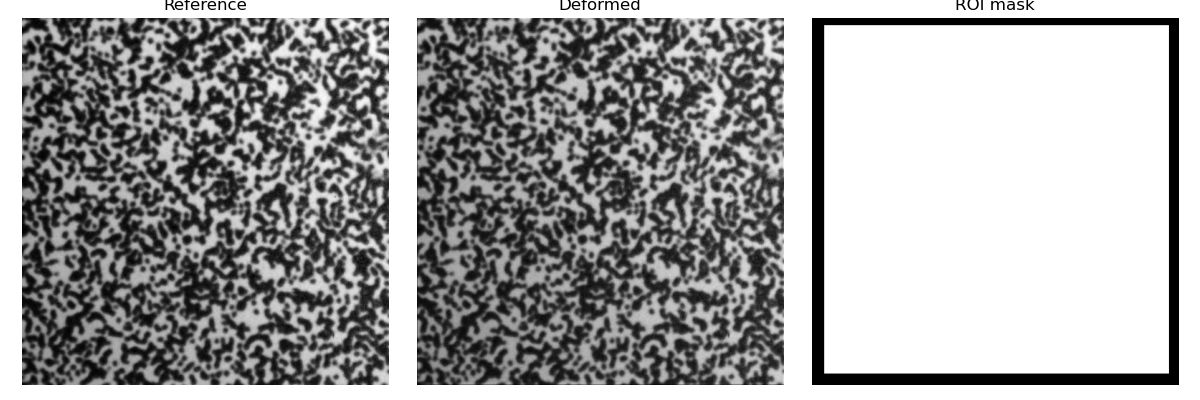

In [2]:
repo_root = None
current = Path.cwd().resolve()
for candidate in (current, *current.parents):
    img_root = candidate / "doc" / "img" / "Sample3"
    if img_root.exists():
        repo_root = candidate
        break
if repo_root is None:
    raise FileNotFoundError(
        "Could not locate the repository root (doc/img/Sample3 folder missing)."
    )

img_dir = repo_root / "doc" / "img" / "Sample3"
out_dir = Path("./_outputs")
out_dir.mkdir(exist_ok=True)

im_ref = imread(img_dir / "Sample3 Reference.tif").astype(float)
im_def = imread(img_dir / "Sample3-004 X0.40 Y0.40 N2 C0 R0.tif").astype(float)
mask = imread(img_dir / "roi.tif")[:,:,0]

print("im_ref:", im_ref.shape, im_ref.dtype)
print("im_def:", im_def.shape, im_def.dtype)
print("mask :", mask.shape, mask.dtype)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap="gray", origin="lower")
ax[0].set_title("Reference")
ax[1].imshow(im_def, cmap="gray", origin="lower")
ax[1].set_title("Deformed")
ax[2].imshow(mask, cmap="gray", origin="lower")
ax[2].set_title("ROI mask")
for a in ax:
    a.axis("off")
plt.tight_layout()


## 2) Generate an ROI mesh (from the mask)

The mesh is generated once and reused in subsequent runs.

In [3]:
mask_path = img_dir / "roi.tif"
mesh_path = out_dir / "roi_mesh.msh"


mesh_path_generated = generate_roi_mesh(mask_path, element_size=40., msh_path=str(mesh_path))
if mesh_path_generated is None:
    raise RuntimeError("Mesh generation failed.")
mesh_path = Path(mesh_path_generated)

mesh_path

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000142712s, CPU 0.000172s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Blossom: 595 internal 52 closed
Info    : Blossom recombination completed (Wall 0.00270183s, CPU 0.002744s): 204 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.802746, min Q = 0.510264
Info    : Done meshing 2D (Wall 0.00543557s, CPU 0.005938s)
Info    : 231 nodes 260 elements
Info    : Writing '_outputs/roi_mesh.msh'...
Info    : Done writing '_outputs/roi_mesh.msh'


PosixPath('_outputs/roi_mesh.msh')

## 3) Create the DIC object

We precompute pixel-level quantities (on the reference image).

In [4]:
dic = Dic(mesh_path=str(mesh_path))
dic.precompute_pixel_data(jnp.asarray(im_ref))

dic

Dic(mesh_path=_outputs/roi_mesh.msh)

## 4) Solve global DIC

Pixelwise solve with spring regularization (`reg_type="spring"`).

Last state: [1.96320546e+00 9.57585755e-04]


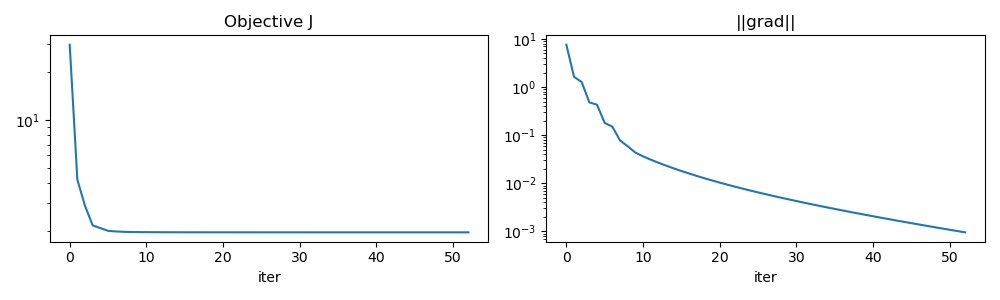

In [5]:
displacement, history = dic.run_dic(
    im_ref,
    im_def,
    disp_guess=None,
    max_iter=400,
    tol=1e-3,
    reg_type="spring",
    alpha_reg=1e-4,
    save_history=True,
)

hist = np.asarray(history)
print("Last state:", hist[-1])

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].semilogy(hist[:, 0])
ax[0].set_title("Objective J")
ax[0].set_xlabel("iter")
ax[1].semilogy(hist[:, 1])
ax[1].set_title("||grad||")
ax[1].set_xlabel("iter")
plt.tight_layout()

## 5) Visualize the displacement field

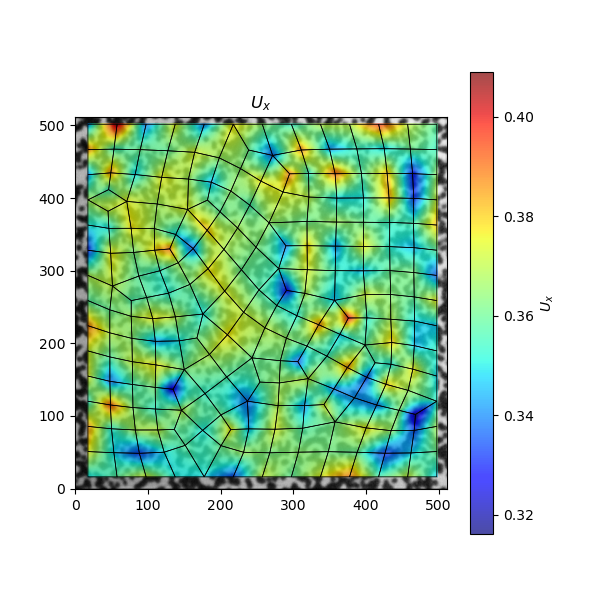

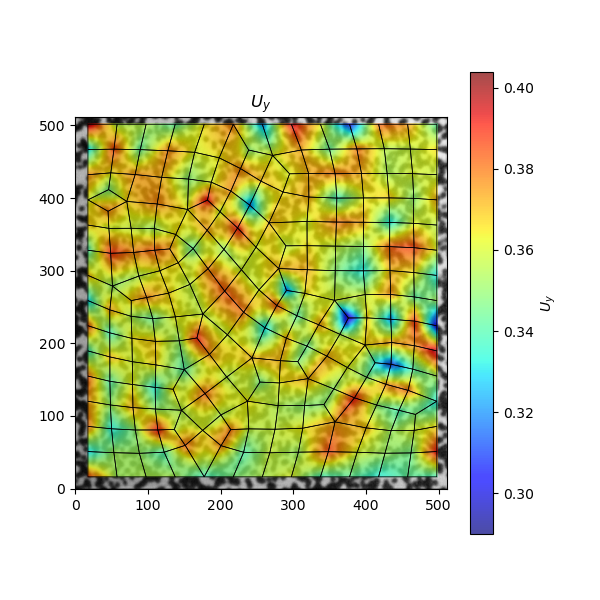

In [6]:
plotter = DICPlotter(
    background_image=im_def,
    displacement=np.asarray(displacement),
    dic_object=dic,
)

fig, _ = plotter.plot_displacement_component("Ux", image_alpha=0.7,plotmesh=True )
plt.show()
fig, _ = plotter.plot_displacement_component("Uy", image_alpha=0.7,plotmesh=True )
plt.show()

In [7]:
# displacement measurment
#mean displacement in pixels
Ux_mean = jnp.mean(displacement[:, 0])
Uy_mean = jnp.mean(displacement[:, 1])
print(f"Mean displacement: Ux = {Ux_mean:.6f} px, Uy = {Uy_mean:.6f} px")
# std of displacement in pixels
Ux_std = jnp.std(displacement[:, 0])
Uy_std = jnp.std(displacement[:, 1])
print(f"Displacement std: Ux = {Ux_std:.6f} px, Uy = {Uy_std:.6f} px")

Mean displacement: Ux = 0.361008 px, Uy = 0.359974 px
Displacement std: Ux = 0.015532 px, Uy = 0.019031 px


## 6) Conclusions
This validation notebook focused on a rigid body motion test case, for which the expected displacement was 0.4 pixels in both the X and Y directions. The correlation results yield mean displacements of 0.36 pixels along each axis, with standard deviations of 0.015 for 𝑈𝑥 and 0.016 for 𝑈𝑦. 

These values are in good agreement with the prescribed motion and demonstrate that the implemented correlation framework correctly captures rigid body translations. 

Although the measured displacements slightly underestimate the reference values and the associated uncertainties indicate a limited level of precision, this behavior is consistent with the fact that the correlation method used here, while robust and well established, does not represent the current state of the art in digital image correlation techniques. 

Nevertheless, this validation provides confidence in the correctness and reliability of the present implementation, which constitutes a sound basis for further developments and more advanced correlation strategies.